In [1]:
import pandas as pd

ds_text = pd.read_csv("news-articles-united-airline_social-animal_201601-201905.txt",sep='|')

# Data Processing

In [2]:
import nltk
import nltk.corpus
import ast
import numpy as np

import re
import string
PUNCT_TO_REMOVE = string.punctuation

from nltk import word_tokenize
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))

from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer('english')

def text_processing(text):
    text = text.lower()
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'', text)
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    text = " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in str(text).split()])
    return text

In [3]:
ds_cluster = ds_text[['content_word_count','deep_keywords','domain','sentiment','title']]
ds_cluster['domain'] = ds_cluster['domain'].astype('category').cat.codes
ds_cluster['title'] = ds_cluster['title'].apply(lambda x: text_processing(x))
ds_cluster['deep_keywords'] = ds_cluster['deep_keywords'].fillna('[]')
ds_cluster['deep_keywords'] = ds_cluster['deep_keywords'].apply(lambda x: ' '.join(ast.literal_eval(x)))

<ipython-input-3-e77662b3add5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster['domain'] = ds_cluster['domain'].astype('category').cat.codes
<ipython-input-3-e77662b3add5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster['title'] = ds_cluster['title'].apply(lambda x: text_processing(x))
<ipython-input-3-e77662b3add5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

# TfIdf Vector & Compose training data

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_title = TfidfVectorizer(max_features=3000)
X_title = vectorizer_title.fit_transform(ds_cluster['title']).toarray()
vectorizer_keywords = TfidfVectorizer(max_features=3000)
X_keywords = vectorizer_keywords.fit_transform(ds_cluster['deep_keywords']).toarray()

X_cluster = np.hstack((X_title,X_keywords))
df_train = pd.DataFrame(X_cluster).fillna(0)

In [5]:
terms_title = vectorizer_title.get_feature_names()
terms_keywords = vectorizer_keywords.get_feature_names()

# Choose appropriate cluster numbers

In [7]:
'''
    Use keywords and title tfidf as training data. Choose the best cluster number using sse value and cluster training data
    with the best cluster number. Get title and keywords of each cluster.
'''
from sklearn.cluster import KMeans

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 200,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_train)
    sse.append(kmeans.inertia_)

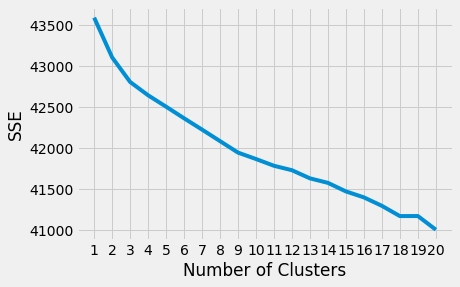

In [8]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [9]:
from kneed import KneeLocator

kl = KneeLocator(range(1, 21), sse, curve="convex", direction="decreasing")
print('best cluster number:',kl.elbow)

best cluster number: 9


In [10]:
number_of_clusters = 9

model = KMeans(n_clusters = number_of_clusters, 
               init = 'k-means++', 
               max_iter = 200, 
               n_init = 10,
               random_state=42)

model.fit(df_train)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

In [11]:
for i in range(number_of_clusters):
    print("Cluster %d:" % (i+1))
    list_title = []
    list_keywords = []
    for ind in order_centroids[i,:20]:        
        if ind < 3000:
            list_title.append(terms_title[ind])
        else:
            list_keywords.append(terms_keywords[ind-3000])
    print('Title: %s \nKeywords: %s\n' % (','.join(list_title),','.join(list_keywords)))

Cluster 1:
Title: airlin,flight,unit,new,travel,us,roundtrip 
Keywords: airlines,flight,united,new,trump,flights,american,airline,york,business,google,company,years

Cluster 2:
Title: delta,airlin,flight,line,nra,air,unit,us 
Keywords: delta,lines,airlines,air,united,american,nra,flight,southwest,airline,flights,passengers

Cluster 3:
Title: unit,airlin,flight,passeng,new 
Keywords: united,airlines,flight,airline,american,flights,passengers,customers,plane,seats,service,states,passenger,chicago,uniteds

Cluster 4:
Title: air,mesa,group,canada,new,inc,zealand,flight 
Keywords: air,mesa,canada,group,zealand,airlines,wisconsin,new,india,united,flights,flight

Cluster 5:
Title: airport,flight,intern,passeng,new,airlin,newark,unit,chicago 
Keywords: airport,airlines,united,newark,international,chicago,flight,airports,flights,passengers,hare

Cluster 6:
Title: max,boe,737,ground,crash,jet,airlin,us 
Keywords: boeing,max,airlines,aircraft,planes,pilots,faa,plane,southwest,jets,united,ethiopia

# Add sentiment, domain and apply standard scaler

In [ ]:
'''
add sentiment and domain value into training dataset and apply standard scaler.
'''
from sklearn.preprocessing import StandardScaler
    
X_cluster_scale = np.hstack((ds_cluster.drop(columns=['title','deep_keywords']).values,X_title,X_keywords))
df_train_s = pd.DataFrame(X_cluster).fillna(0)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_s)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 200,
    "random_state": 42,
}

sse_scale = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    sse_scale.append(kmeans.inertia_)

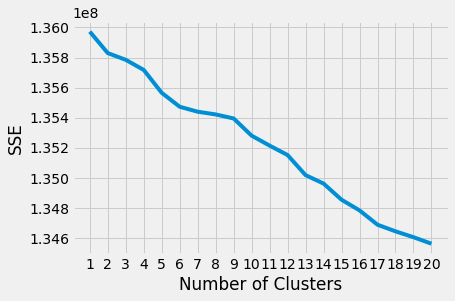

In [16]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse_scale)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [30]:
kl_scale = KneeLocator(range(1, 21), sse, curve="convex", direction="decreasing")
number_of_clusters = kl_scale.elbow

model_scale = KMeans(n_clusters = number_of_clusters, 
               init = 'k-means++', 
               max_iter = 200, 
               n_init = 10,
               random_state=42)

model_scale.fit(df_scaled)

order_centroids_scale = model_scale.cluster_centers_.argsort()[:, ::-1]

In [31]:
for i in range(number_of_clusters):
    print("Cluster %d:" % (i+1))
    list_title = []
    list_keywords = []
    for ind in order_centroids_scale[i,:20]:        
        if 2 < ind < 3003:
            list_title.append(terms_title[ind-3])
        elif ind>=3003:
            list_keywords.append(terms_keywords[ind-3003])
        else:
            continue
    print('Title: %s \nKeywords: %s\n' % (','.join(list_title),','.join(list_keywords)))

Cluster 1:
Title: carat,headlin,healthi,78710,aerospac,taxi,175,wasnt,nra 
Keywords: carbon,mendoza,ok,headley,central,announcement,keith,fargo,theresa,edmonton,metro

Cluster 2:
Title: floor,halifax,todd,spice,strong,teigen,emir,sunday,within,citi,sue,save 
Keywords: alan,halts,beer,peacock,today,spending,strike,help

Cluster 3:
Title: navi,ryanair,trap,influenc,contest,interpret,exposur,remot,planet 
Keywords: nbc,travelers,ryanair,rhapsody,consumer,evidence,sofia,disney,husband,hawthorne,african

Cluster 4:
Title: lax,poll,dc10,delhi,final,document,destroy,dick 
Keywords: alaska,delivery,orlando,lawsuit,messenger,deliveries,europe,destination,dell,linda,documents,philadelphia

Cluster 5:
Title: heart,3x,ithaca,dreamlin,stepbystep,fool,turbul,miami,retali,within,pictur 
Keywords: value,miami,heart,sense,mph,locker,shelter,crj,december

Cluster 6:
Title: uniform,network,blunder,upon,transport,seri,materi 
Keywords: unions,flier,amendment,september,airasia,boards,pascolla,mile,chengdu,

# Classification Result

In [13]:
'''
The cluster result is better when use title and keywords as training data only.
'''
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_train.index.values
cluster_map['title'] = ds_text['title'].values
cluster_map['cluster'] = model.labels_
cluster_map['cluster'].value_counts()

0    12840
2     4430
4     1221
8      953
5      865
1      716
3      600
7      595
6      442
Name: cluster, dtype: int64

In [15]:
cluster_map.to_csv('text cluster result.csv')

In [52]:
cluster_map_scale = pd.DataFrame()
cluster_map_scale['data_index'] = df_train_s.index.values
cluster_map_scale['title'] = ds_text['title'].values
cluster_map_scale['cluster'] = model_scale.labels_
cluster_map_scale['cluster'].value_counts()

5    22427
1       77
3       57
0       40
6       29
2       23
4        9
Name: cluster, dtype: int64